# CycleGAN, Image-to-Image Translation

In this notebook, we're going to define and train a CycleGAN to read in an image from a set $X$ and transform it so that it looks as if it belongs in set $Y$. Specifically, we'll look at a set of images of [Yosemite national park](https://en.wikipedia.org/wiki/Yosemite_National_Park) taken either during the summer of winter. The seasons are the two domains that we will work on.

### Unpaired Training Data

CycleGANs give us a way to learn the mapping between one image domain and another using an **unsupervised** approach. A CycleGAN is designed for image-to-image translation and it learns from unpaired training data. This means that in order to train a generator to translate images from domain $X$ to domain $Y$, we do not have to have exact correspondences between individual images in those domains. For example, in [the paper that introduced CycleGANs](https://arxiv.org/abs/1703.10593), the authors are able to translate between images of horses and zebras, even though there are no images of a zebra in exactly the same position as a horse or with exactly the same background, etc.

<img src='assets/horse2zebra.jpg' width=50% />

>1. We'll load in the image data using PyTorch's DataLoader class to efficiently read in images from a specified directory. 
2. We'll define the discriminator and the generator models CycleGAN architecture according to provided specifications.
3. We'll complete the training cycle by calculating the adversarial and cycle consistency losses for the generator and discriminator network and completing a number of training epochs.
4. Finally, we'll evaluate the model by looking at the loss over time.


---

## Load and Visualize the Data

We'll first load in and visualize the training data, importing the necessary libraries to do so.

In [1]:
# loading in and transforming data
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# visualizing data
import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline

### DataLoaders

In [2]:
def get_data_loader(image_type, image_dir='summer2winter-yosemite', 
                    image_size=128, batch_size=16, num_workers=0):
    """Returns training and test data loaders for a given image type, either 'summer' or 'winter'. 
       These images will be resized to 128x128x3, by default, converted into Tensors, and normalized.
    """
    
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size), # resize to 128x128
                                    transforms.ToTensor()])

    # get training and test directories
    image_path = './' + image_dir
    train_path = os.path.join(image_path, image_type)
    test_path = os.path.join(image_path, 'test_{}'.format(image_type))

    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    # construct and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [3]:
# Construct train and test dataloaders for images from the two domains X and Y
# image_type = directory names for our data
dataloader_X, test_dataloader_X = get_data_loader(image_type='summer')
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='winter')

## Display some Training Images

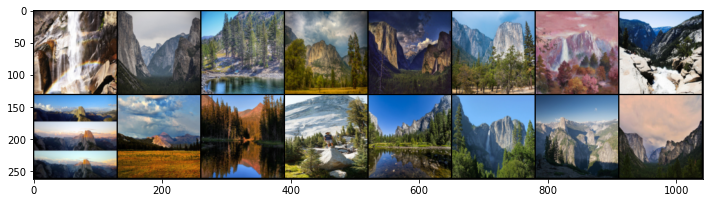

In [4]:
# helper imshow function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

# get some images from X
dataiter = iter(dataloader_X)
# the "_" is a placeholder for no labels
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))

Next, let's visualize a batch of images from set $Y$.

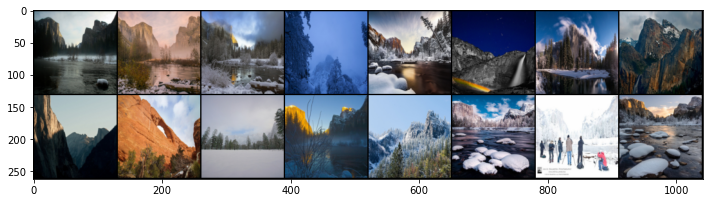

In [5]:
# get some images from Y
dataiter = iter(dataloader_Y)
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(images))

### Pre-processing: scaling from -1 to 1

We need to do a bit of pre-processing; we know that the output of our `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.)
Max:  tensor(0.9961)


In [7]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [8]:
# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-1.)
Scaled max:  tensor(0.9922)


---
## Define the Model

A CycleGAN is made of two discriminator and two generator networks.

## Discriminators

The discriminators, $D_X$ and $D_Y$, in this CycleGAN are convolutional neural networks that see an image and attempt to classify it as real or fake. In this case, real is indicated by an output close to 1 and fake as close to 0. The discriminators have the following architecture:

<img src='assets/discriminator_layers.png' width=80% />

This network sees a 128x128x3 image, and passes it through 5 convolutional layers that downsample the image by a factor of 2. The first four convolutional layers have a BatchNorm and ReLu activation function applied to their output, and the last acts as a classification layer that outputs a prediction map with depth of one. In the original paper, the authors passed a 4x4 kernel with stride of 1 in the final convolutional layer.

### Convolutional Helper Function

To define the discriminators, below function constructs a convolutional layer + an optional batch norm layer.

In [9]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Constructs a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

### Define the Discriminator Architecture

In [10]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()

        # Define all convolutional layers
        # Should accept an RGB image as input and output a single value
        
        # input: 3x128x128
        self.seq1 = conv(3, conv_dim, 4, batch_norm=False)
        # out: 64x64x64
        self.seq2 = conv(conv_dim, conv_dim*2, 4)
        # out: 128x32x32
        self.seq3 = conv(conv_dim*2, conv_dim*4, 4)
        # out: 256x16x16
        self.seq4 = conv(conv_dim*4, conv_dim*8, 4)
        # out: 512x8x8
        
        # classification layer
        self.seq5 = conv(conv_dim*8, 1, 8, stride=1, padding=0, batch_norm=False)
        # out: 1x1x1
        # (8 - 8 + 2x0 ) / 1 + 1 = 1 

    def forward(self, x):
        # define feedforward behavior
        
        x = F.relu(self.seq1(x))
        x = F.relu(self.seq2(x))
        x = F.relu(self.seq3(x))
        x = F.relu(self.seq4(x))
        x = self.seq5(x)
        
        return x

## Generators

The generators, `G_XtoY` and `G_YtoX` (sometimes called F), are made of an **encoder**, a conv net that is responsible for turning an image into a smaller feature representation, and a **decoder**, a *transpose_conv* net that is responsible for turning that representation into an transformed image. These generators, one from XtoY and one from YtoX, have the following architecture:

<img src='assets/cyclegan_generator_ex.png' width=90% />

This network sees a 128x128x3 image, compresses it into a feature representation as it goes through three convolutional layers and reaches a series of residual blocks. It goes through a few (typically 6 or more) of these residual blocks, then it goes through three transpose convolutional layers (sometimes called *de-conv* layers) which upsample the output of the resnet blocks and form a new image.

---
### Residual Block Class

<img src='notebook_images/resnet_50.png' width=90%/>

ResNet blocks rely on connecting the output of one layer with the input of an earlier layer. The motivation for this structure is as follows: very deep neural networks can be difficult to train. Deeper networks are more likely to have vanishing or exploding gradients and, therefore, have trouble reaching convergence. During training, we often see that deep networks respond with a kind of training degradation. Essentially, the training accuracy stops improving and gets saturated at some point during training.

One solution to this problem is to use **Resnet blocks** that allow us to learn so-called *residual functions* as they are applied to layer inputs. More about this proposed architecture can be accessed in the paper, [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf) by Kaiming He et. al, and the below image is from that paper.

<img src='assets/resnet_block.png' width=40%/>

### Residual Functions

#### Optimizing a Residual Function

The idea is that it is to optimize a residual function `F(x)` rather than to optimize the original mapping `M(x)`. 

### Defining the `ResidualBlock` Class

To define the `ResidualBlock` class, we'll define residual functions (a series of layers), apply them to an input x and add them to that same input.

In our case, we'll want to define the residual block as:
* Two convolutional layers with the same size input and output
* Batch normalization applied to the outputs of the convolutional layers
* A ReLu function on the output of the *first* convolutional layer

In [11]:
# residual block class
class ResidualBlock(nn.Module):
    """Defines a residual block.
       This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        # conv_dim = number of inputs
        self.conv_dim = conv_dim
        
        # define two convolutional layers + batch normalization that will act as our residual function, F(x)
        # layers should have the same shape input as output
        self.res_conv1 =  conv(in_channels=conv_dim, out_channels=conv_dim, kernel_size=3, 
                                   padding=1, stride=1, batch_norm=True)
        self.res_conv2 = conv(conv_dim, conv_dim, 3, padding=1, stride=1)
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        f_x = F.relu(self.res_conv1(x))
        f_x = self.res_conv2(x)
        x = x + f_x
        
        return x
    

### Transpose Convolutional Helper Function

In [12]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Constructs a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

---
## Define the Generator Architecture

Both $G_{XtoY}$ and $G_{YtoX}$ have the same architecture, so we only need to define one class, and later instantiate two generators.

In [13]:
class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()

        # 1. Define the encoder part of the generator
        self.encoder = nn.Sequential( 
                                    conv(3, conv_dim, 4), # kernel size:4, stride:2, padding:1 -> out: N/2
                                    nn.ReLU(),
                                    conv(conv_dim, conv_dim*2, 4),   # batch_norm is default set to True
                                    nn.ReLU(),
                                    conv(conv_dim*2, conv_dim*4, 4),
                                    nn.ReLU()
        )

        # 2. Define the resnet part of the generator
        self.residual_blocks = nn.Sequential( *( [ResidualBlock(conv_dim*4)] * n_res_blocks) )

        # 3. Define the decoder part of the generator
        self.decoder = nn.Sequential( 
                                    deconv(conv_dim*4, conv_dim*2, 4),
                                    nn.ReLU(),
                                    deconv(conv_dim*2, conv_dim, 4),
                                    nn.ReLU(),
                                    deconv(conv_dim, 3, 4, batch_norm=False),
        )

    def forward(self, x):
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary

        x = self.encoder(x)
        x = self.residual_blocks(x)
        x = F.tanh(self.decoder(x))
        return x

---
## Construct the complete network

First, construct two discriminators, one for checking if $X$ sample images are real, and one for checking if $Y$ sample images are real. Then the generators. Instantiate two of them, one for transforming a painting into a realistic photo and one for transforming a photo into a painting.

In [14]:
def construct_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    """Builds the generators and discriminators."""
    
    # Instantiate generators
    G_XtoY = CycleGenerator(g_conv_dim, n_res_blocks)
    G_YtoX = CycleGenerator(g_conv_dim, n_res_blocks)
    # Instantiate discriminators
    D_X = Discriminator(d_conv_dim)
    D_Y = Discriminator(d_conv_dim)

    # move models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [15]:
# call the function to get models
G_XtoY, G_YtoX, D_X, D_Y = construct_model()

Models moved to GPU.


## Check implementation

In [16]:
# helper function for printing the model architecture
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()
    

# print all of the models
print_models(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
CycleGenerator(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ReLU()
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): ReLU()
    (4): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): ReLU()
  )
  (residual_blocks): Sequential(
    (0): ResidualBlock(
      (res_conv1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     

## Discriminator and Generator Losses

Computing the discriminator and the generator losses are key to getting a CycleGAN to train.

<img src='assets/CycleGAN_loss.png' width=90% height=90% />

**Image from [original paper](https://arxiv.org/abs/1703.10593) by Jun-Yan Zhu et. al.**

* The CycleGAN contains two mapping functions $G: X \rightarrow Y$ and $F: Y \rightarrow X$, and associated adversarial discriminators $D_Y$ and $D_X$. **(a)** $D_Y$ encourages $G$ to translate $X$ into outputs indistinguishable from domain $Y$, and vice versa for $D_X$ and $F$.

* To further regularize the mappings, we introduce two cycle consistency losses that capture the intuition that if
we translate from one domain to the other and back again we should arrive at where we started. **(b)** Forward cycle-consistency loss and **(c)** backward cycle-consistency loss.

## Least Squares GANs

Regular GAN's sigmoid cross entropy loss function may lead to the vanishing gradients problem during the learning process. To overcome such a problem, we'll use a least squares loss function for the discriminator. This structure is also referred to as a least squares GAN or LSGAN, and we can [read the original paper on LSGANs, here](https://arxiv.org/pdf/1611.04076.pdf). The authors show that LSGANs are able to generate higher quality images than regular GANs and that this loss type is a bit more stable during training. 

### Discriminator Losses

The discriminator losses will be mean squared errors between the output of the discriminator, given an image, and the target value, 0 or 1, depending on whether it should classify that image as fake or real. For example, for a *real* image, `x`, we can train $D_X$ by looking at how close it is to recognizing and image `x` as real using the mean squared error:

```
out_x = D_X(x)
real_err = torch.mean((out_x-1)**2)
```

### Generator Losses

#### Cycle Consistency Loss

In addition to the adversarial losses, the generator loss terms will also include the **cycle consistency loss**. This loss is a measure of how good a reconstructed image is, when compared to an original image. 

Say we have a fake, generated image, `x_hat`, and a real image, `y`. We can get a reconstructed `y_hat` by applying `G_XtoY(x_hat) = y_hat` and then check to see if this reconstruction `y_hat` and the orginal image `y` match. For this, we recommend calculating the L1 loss, which is an absolute difference, between reconstructed and real images. We may also choose to multiply this loss by some weight value `lambda_weight` to convey its importance.

<img src='assets/reconstruction_error.png' width=40% height=40% />

The total generator loss will be the sum of the generator losses and the forward and backward cycle consistency losses.

---
### Define Loss Functions

To help us calculate the discriminator and gnerator losses during training, let's define some helpful loss functions. Here, we'll define three.
1. `real_mse_loss` that looks at the output of a discriminator and returns the error based on how close that output is to being classified as real. This should be a mean squared error.
2. `fake_mse_loss` that looks at the output of a discriminator and returns the error based on how close that output is to being classified as fake. This should be a mean squared error.
3. `cycle_consistency_loss` that looks at a set of real image and a set of reconstructed/generated images, and returns the mean absolute error between them. This has a `lambda_weight` parameter that will weight the mean absolute error in a batch.


In [17]:
def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    real_loss = torch.mean(torch.square(D_out - 1))
    return real_loss

def fake_mse_loss(D_out):
    # how close is the produced output from being "fake"?
    fake_loss = torch.mean(torch.square(D_out))
    return fake_loss

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight=10):
    # calculate reconstruction loss 
    # criterion = nn.L1Loss()
    reconst_loss = torch.mean(torch.abs(reconstructed_im - real_im)) 
    # return weighted loss
    reconst_loss = reconst_loss * lambda_weight
    return reconst_loss
    


### Define the Optimizers

Next, let's define how this model will update its weights. Hyperparameter values are set from the [CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf).


In [18]:
import torch.optim as optim

# hyperparams for Adam optimizers
lr= 0.0002
beta1= 0.5
beta2= 0.999

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())  # Get generator parameters

# Construct optimizers for the generators and discriminators
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

---

## Training a CycleGAN

When a CycleGAN trains, and sees one batch of real images from set $X$ and $Y$, it trains by performing the following steps:

**Training the Discriminators**
1. Compute the discriminator $D_X$ loss on real images
2. Generate fake images that look like domain $X$ based on real images in domain $Y$
3. Compute the fake loss for $D_X$
4. Compute the total loss and perform backpropagation and $D_X$ optimization
5. Repeat steps 1-4 only with $D_Y$ and domains switched!


**Training the Generators**
1. Generate fake images that look like domain $X$ based on real images in domain $Y$
2. Compute the generator loss based on how $D_X$ responds to fake $X$
3. Generate *reconstructed* $\hat{Y}$ images based on the fake $X$ images generated in step 1
4. Compute the cycle consistency loss by comparing the reconstructions with real $Y$ images
5. Repeat steps 1-4 only swapping domains
6. Add up all the generator and reconstruction losses and perform backpropagation + optimization

<img src='assets/cycle_consistency_ex.png' width=70% />


### Saving Progress

In [19]:
# import save code
from helpers import save_samples, checkpoint

In [20]:
# train the network
def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, 
                  n_epochs=1000):
    
    print_every=10
    
    # keep track of losses over time
    losses = []

    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_X = test_iter_X.next()[0]
    fixed_Y = test_iter_Y.next()[0]
    fixed_X = scale(fixed_X) # make sure to scale to a range -1 to 1
    fixed_Y = scale(fixed_Y)

    # batches per epoch
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(1, n_epochs+1):

        # Reset iterators for each epoch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)

        images_X, _ = iter_X.next()
        images_X = scale(images_X) # make sure to scale to a range -1 to 1

        images_Y, _ = iter_Y.next()
        images_Y = scale(images_Y)
        
        # move images to GPU if available (otherwise stay on CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)


        torch.autograd.set_detect_anomaly(True)
        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        ##   First: D_X, real and fake loss components   ##

        # clear grad 
        d_x_optimizer.zero_grad()
        
        # 1. Compute the discriminator losses on real images
        D_x_output = D_X(images_X)
        d_x_real_loss = real_mse_loss(D_x_output)
        
        # 2. Generate fake images that look like domain X based on real images in domain Y
        G_x_images = G_YtoX(images_Y)
        G_x_output = D_X(G_x_images)
        
        # 3. Compute the fake loss for D_X
        d_x_fake_loss = fake_mse_loss(G_x_output)
        
        # 4. Compute the total loss and perform backprop
        d_x_loss = d_x_real_loss + d_x_fake_loss
        d_x_loss.backward()
        d_x_optimizer.step()
        
        
        ##   Second: D_Y, real and fake loss components   ##
        
        # clear grad
        d_y_optimizer.zero_grad()
        
        # D loss based on real images
        D_y_output = D_Y(images_Y)
        d_y_real_loss = real_mse_loss(D_y_output)
        
        # generate images
        G_y_images = G_XtoY(images_X)
        G_y_output = D_Y(G_y_images)
        
        # D loss based on generated images
        d_y_fake_loss = fake_mse_loss(G_y_output)
        
        # optimize
        d_y_loss = d_y_real_loss + d_y_fake_loss
        d_y_loss.backward()
        d_y_optimizer.step()


        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        ##    First: generate fake X images and reconstructed Y images    ##
        

        # 1. Generate fake images that look like domain X based on real images in domain Y
        generated_X_images = G_YtoX(images_Y)
        

        # 2. Compute the generator loss based on domain X
        D_x_output = D_X(generated_X_images)  
        g_x_loss = real_mse_loss(D_x_output)

        # 3. Form a reconstructed y
        reconstructed_Y_images = G_XtoY(generated_X_images)
        
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        cycle_loss_y = cycle_consistency_loss(images_Y, reconstructed_Y_images)

        ##    Second: generate fake Y images and reconstructed X images    ##
        generated_Y_images = G_XtoY(images_X)
        
        D_y_output = D_Y(generated_Y_images)
        g_y_loss = real_mse_loss(D_y_output)
        
        reconstructed_X_images = G_YtoX(generated_Y_images)
        
        cycle_loss_x = cycle_consistency_loss(images_X, reconstructed_X_images)
        
        
        # 5. Add up all generator and reconstructed losses and perform backprop
        g_total_loss = g_x_loss + g_y_loss + cycle_loss_y + cycle_loss_x
        g_total_loss.backward()
        g_optimizer.step()

        
        # Print the log info
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

            
        sample_every=100
        # Save the generated samples
        if epoch % sample_every == 0:
            G_YtoX.eval() # set generators to eval mode for sample generation
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16)
            G_YtoX.train()
            G_XtoY.train()

        # save model
        checkpoint_every=1000
        # Save the model parameters
        if epoch % checkpoint_every == 0:
            checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses


In [21]:
n_epochs = 1000 # keep this small when testing if a model first works, then increase it to >=1000

losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)

Epoch [   10/ 1000] | d_X_loss: 0.4527 | d_Y_loss: 0.3273 | g_total_loss: 14.9027
Epoch [   20/ 1000] | d_X_loss: 0.6692 | d_Y_loss: 3.4246 | g_total_loss: 27.4186
Epoch [   30/ 1000] | d_X_loss: 0.5716 | d_Y_loss: 0.3944 | g_total_loss: 10.2473
Epoch [   40/ 1000] | d_X_loss: 0.2715 | d_Y_loss: 2.6755 | g_total_loss: 14.3910
Epoch [   50/ 1000] | d_X_loss: 0.1843 | d_Y_loss: 0.2095 | g_total_loss: 11.0759
Epoch [   60/ 1000] | d_X_loss: 1.2180 | d_Y_loss: 0.1080 | g_total_loss: 9.5028
Epoch [   70/ 1000] | d_X_loss: 1.3408 | d_Y_loss: 1.6587 | g_total_loss: 9.3609
Epoch [   80/ 1000] | d_X_loss: 0.5615 | d_Y_loss: 0.1961 | g_total_loss: 10.1097
Epoch [   90/ 1000] | d_X_loss: 0.2951 | d_Y_loss: 0.3315 | g_total_loss: 8.5301


Epoch [  100/ 1000] | d_X_loss: 0.2147 | d_Y_loss: 0.1442 | g_total_loss: 7.5976


Saved samples_cyclegan\sample-000100-X-Y.png
Saved samples_cyclegan\sample-000100-Y-X.png
Epoch [  110/ 1000] | d_X_loss: 0.1595 | d_Y_loss: 0.5960 | g_total_loss: 8.6069
Epoch [  120/ 1000] | d_X_loss: 0.0839 | d_Y_loss: 0.2060 | g_total_loss: 7.0694
Epoch [  130/ 1000] | d_X_loss: 0.7655 | d_Y_loss: 0.8481 | g_total_loss: 10.7915
Epoch [  140/ 1000] | d_X_loss: 0.2385 | d_Y_loss: 0.4736 | g_total_loss: 7.4988
Epoch [  150/ 1000] | d_X_loss: 0.4675 | d_Y_loss: 0.4790 | g_total_loss: 6.1659
Epoch [  160/ 1000] | d_X_loss: 1.7733 | d_Y_loss: 0.1865 | g_total_loss: 11.9559
Epoch [  170/ 1000] | d_X_loss: 0.2715 | d_Y_loss: 0.1386 | g_total_loss: 7.5568
Epoch [  180/ 1000] | d_X_loss: 0.1232 | d_Y_loss: 0.0693 | g_total_loss: 7.2914
Epoch [  190/ 1000] | d_X_loss: 0.1320 | d_Y_loss: 0.2232 | g_total_loss: 8.0336


Epoch [  200/ 1000] | d_X_loss: 0.4242 | d_Y_loss: 1.8120 | g_total_loss: 7.4246


Saved samples_cyclegan\sample-000200-X-Y.png
Saved samples_cyclegan\sample-000200-Y-X.png
Epoch [  210/ 1000] | d_X_loss: 0.1909 | d_Y_loss: 0.1720 | g_total_loss: 7.7333
Epoch [  220/ 1000] | d_X_loss: 0.0919 | d_Y_loss: 0.2008 | g_total_loss: 7.8964
Epoch [  230/ 1000] | d_X_loss: 0.1013 | d_Y_loss: 0.4446 | g_total_loss: 7.4881
Epoch [  240/ 1000] | d_X_loss: 1.6499 | d_Y_loss: 0.4385 | g_total_loss: 7.9432
Epoch [  250/ 1000] | d_X_loss: 0.2182 | d_Y_loss: 0.3989 | g_total_loss: 6.8957
Epoch [  260/ 1000] | d_X_loss: 0.2991 | d_Y_loss: 0.1616 | g_total_loss: 7.3953
Epoch [  270/ 1000] | d_X_loss: 0.0668 | d_Y_loss: 0.1094 | g_total_loss: 6.8924
Epoch [  280/ 1000] | d_X_loss: 0.2075 | d_Y_loss: 0.1238 | g_total_loss: 6.9151
Epoch [  290/ 1000] | d_X_loss: 0.0914 | d_Y_loss: 0.1248 | g_total_loss: 7.9891


Epoch [  300/ 1000] | d_X_loss: 0.1344 | d_Y_loss: 0.0805 | g_total_loss: 6.6624


Saved samples_cyclegan\sample-000300-X-Y.png
Saved samples_cyclegan\sample-000300-Y-X.png
Epoch [  310/ 1000] | d_X_loss: 0.2592 | d_Y_loss: 0.2881 | g_total_loss: 7.1549
Epoch [  320/ 1000] | d_X_loss: 0.2629 | d_Y_loss: 0.0868 | g_total_loss: 7.6014
Epoch [  330/ 1000] | d_X_loss: 0.1105 | d_Y_loss: 0.1267 | g_total_loss: 6.7665
Epoch [  340/ 1000] | d_X_loss: 0.6578 | d_Y_loss: 0.1501 | g_total_loss: 8.1419
Epoch [  350/ 1000] | d_X_loss: 0.0757 | d_Y_loss: 0.0405 | g_total_loss: 6.4154
Epoch [  360/ 1000] | d_X_loss: 0.1002 | d_Y_loss: 0.2716 | g_total_loss: 7.7759
Epoch [  370/ 1000] | d_X_loss: 0.1477 | d_Y_loss: 0.0949 | g_total_loss: 7.1453
Epoch [  380/ 1000] | d_X_loss: 0.4372 | d_Y_loss: 0.1985 | g_total_loss: 6.0746
Epoch [  390/ 1000] | d_X_loss: 0.2733 | d_Y_loss: 0.1979 | g_total_loss: 6.5394


Epoch [  400/ 1000] | d_X_loss: 0.1132 | d_Y_loss: 0.3521 | g_total_loss: 5.9712


Saved samples_cyclegan\sample-000400-X-Y.png
Saved samples_cyclegan\sample-000400-Y-X.png
Epoch [  410/ 1000] | d_X_loss: 0.7250 | d_Y_loss: 0.4750 | g_total_loss: 10.3799
Epoch [  420/ 1000] | d_X_loss: 0.3377 | d_Y_loss: 0.1094 | g_total_loss: 7.5460
Epoch [  430/ 1000] | d_X_loss: 0.0972 | d_Y_loss: 0.3170 | g_total_loss: 6.3674
Epoch [  440/ 1000] | d_X_loss: 0.1533 | d_Y_loss: 0.5567 | g_total_loss: 5.8053
Epoch [  450/ 1000] | d_X_loss: 0.3089 | d_Y_loss: 0.1093 | g_total_loss: 7.1950
Epoch [  460/ 1000] | d_X_loss: 0.2523 | d_Y_loss: 1.1236 | g_total_loss: 6.3151
Epoch [  470/ 1000] | d_X_loss: 0.1154 | d_Y_loss: 0.1756 | g_total_loss: 8.1400
Epoch [  480/ 1000] | d_X_loss: 0.0782 | d_Y_loss: 0.1080 | g_total_loss: 7.6391
Epoch [  490/ 1000] | d_X_loss: 0.3201 | d_Y_loss: 0.2292 | g_total_loss: 7.6599
Epoch [  500/ 1000] | d_X_loss: 0.1414 | d_Y_loss: 1.3560 | g_total_loss: 5.6224


Saved samples_cyclegan\sample-000500-X-Y.png
Saved samples_cyclegan\sample-000500-Y-X.png
Epoch [  510/ 1000] | d_X_loss: 0.0640 | d_Y_loss: 0.4301 | g_total_loss: 6.9630
Epoch [  520/ 1000] | d_X_loss: 0.1430 | d_Y_loss: 0.0654 | g_total_loss: 6.9545
Epoch [  530/ 1000] | d_X_loss: 0.1285 | d_Y_loss: 0.1085 | g_total_loss: 7.3228
Epoch [  540/ 1000] | d_X_loss: 0.0405 | d_Y_loss: 0.1784 | g_total_loss: 7.3069
Epoch [  550/ 1000] | d_X_loss: 0.1548 | d_Y_loss: 0.2572 | g_total_loss: 7.3672
Epoch [  560/ 1000] | d_X_loss: 0.0430 | d_Y_loss: 0.2537 | g_total_loss: 7.7881
Epoch [  570/ 1000] | d_X_loss: 0.4215 | d_Y_loss: 0.7285 | g_total_loss: 5.4702
Epoch [  580/ 1000] | d_X_loss: 0.5084 | d_Y_loss: 0.0609 | g_total_loss: 6.5913
Epoch [  590/ 1000] | d_X_loss: 0.0362 | d_Y_loss: 0.2850 | g_total_loss: 6.0671


Epoch [  600/ 1000] | d_X_loss: 0.1620 | d_Y_loss: 0.1469 | g_total_loss: 7.4581


Saved samples_cyclegan\sample-000600-X-Y.png
Saved samples_cyclegan\sample-000600-Y-X.png
Epoch [  610/ 1000] | d_X_loss: 1.1925 | d_Y_loss: 0.9250 | g_total_loss: 5.0933
Epoch [  620/ 1000] | d_X_loss: 0.1765 | d_Y_loss: 0.3427 | g_total_loss: 8.4133
Epoch [  630/ 1000] | d_X_loss: 0.0533 | d_Y_loss: 0.1585 | g_total_loss: 6.2858
Epoch [  640/ 1000] | d_X_loss: 0.0408 | d_Y_loss: 0.0949 | g_total_loss: 7.2057
Epoch [  650/ 1000] | d_X_loss: 0.0489 | d_Y_loss: 0.2801 | g_total_loss: 6.9294
Epoch [  660/ 1000] | d_X_loss: 0.3220 | d_Y_loss: 0.6906 | g_total_loss: 6.4102
Epoch [  670/ 1000] | d_X_loss: 0.1418 | d_Y_loss: 0.0326 | g_total_loss: 7.7889
Epoch [  680/ 1000] | d_X_loss: 0.1072 | d_Y_loss: 0.5096 | g_total_loss: 5.8023
Epoch [  690/ 1000] | d_X_loss: 0.2751 | d_Y_loss: 0.0723 | g_total_loss: 8.0532


Epoch [  700/ 1000] | d_X_loss: 0.1312 | d_Y_loss: 0.0619 | g_total_loss: 6.7796


Saved samples_cyclegan\sample-000700-X-Y.png
Saved samples_cyclegan\sample-000700-Y-X.png
Epoch [  710/ 1000] | d_X_loss: 0.7362 | d_Y_loss: 0.3412 | g_total_loss: 5.1108
Epoch [  720/ 1000] | d_X_loss: 0.4396 | d_Y_loss: 0.1018 | g_total_loss: 6.6881
Epoch [  730/ 1000] | d_X_loss: 0.2148 | d_Y_loss: 0.0796 | g_total_loss: 6.9866
Epoch [  740/ 1000] | d_X_loss: 0.0891 | d_Y_loss: 0.0427 | g_total_loss: 6.5967
Epoch [  750/ 1000] | d_X_loss: 0.0612 | d_Y_loss: 0.0814 | g_total_loss: 6.3062
Epoch [  760/ 1000] | d_X_loss: 0.0491 | d_Y_loss: 0.0543 | g_total_loss: 6.6003
Epoch [  770/ 1000] | d_X_loss: 0.2292 | d_Y_loss: 0.1385 | g_total_loss: 7.0094
Epoch [  780/ 1000] | d_X_loss: 0.0964 | d_Y_loss: 0.1928 | g_total_loss: 5.6942
Epoch [  790/ 1000] | d_X_loss: 0.0717 | d_Y_loss: 0.0563 | g_total_loss: 7.2451


Epoch [  800/ 1000] | d_X_loss: 0.0576 | d_Y_loss: 1.1357 | g_total_loss: 6.8397


Saved samples_cyclegan\sample-000800-X-Y.png
Saved samples_cyclegan\sample-000800-Y-X.png
Epoch [  810/ 1000] | d_X_loss: 0.2654 | d_Y_loss: 0.2675 | g_total_loss: 6.1147
Epoch [  820/ 1000] | d_X_loss: 0.0637 | d_Y_loss: 0.1572 | g_total_loss: 7.0983
Epoch [  830/ 1000] | d_X_loss: 0.0620 | d_Y_loss: 0.0830 | g_total_loss: 7.3379
Epoch [  840/ 1000] | d_X_loss: 0.4569 | d_Y_loss: 0.4946 | g_total_loss: 8.1327
Epoch [  850/ 1000] | d_X_loss: 0.0230 | d_Y_loss: 0.0370 | g_total_loss: 6.2928
Epoch [  860/ 1000] | d_X_loss: 0.6237 | d_Y_loss: 0.8145 | g_total_loss: 6.5712
Epoch [  870/ 1000] | d_X_loss: 0.1017 | d_Y_loss: 0.1429 | g_total_loss: 6.4681
Epoch [  880/ 1000] | d_X_loss: 0.0673 | d_Y_loss: 0.0213 | g_total_loss: 6.4672
Epoch [  890/ 1000] | d_X_loss: 0.0635 | d_Y_loss: 0.2317 | g_total_loss: 8.6615


Epoch [  900/ 1000] | d_X_loss: 0.0331 | d_Y_loss: 0.5491 | g_total_loss: 8.0195


Saved samples_cyclegan\sample-000900-X-Y.png
Saved samples_cyclegan\sample-000900-Y-X.png
Epoch [  910/ 1000] | d_X_loss: 0.1331 | d_Y_loss: 0.2023 | g_total_loss: 6.4663
Epoch [  920/ 1000] | d_X_loss: 0.0436 | d_Y_loss: 0.0839 | g_total_loss: 6.3505
Epoch [  930/ 1000] | d_X_loss: 0.0310 | d_Y_loss: 0.0917 | g_total_loss: 7.1243
Epoch [  940/ 1000] | d_X_loss: 0.2592 | d_Y_loss: 0.0654 | g_total_loss: 7.4521
Epoch [  950/ 1000] | d_X_loss: 0.2163 | d_Y_loss: 0.0548 | g_total_loss: 6.9186
Epoch [  960/ 1000] | d_X_loss: 0.2535 | d_Y_loss: 0.0793 | g_total_loss: 6.1499
Epoch [  970/ 1000] | d_X_loss: 0.0458 | d_Y_loss: 0.1551 | g_total_loss: 6.8052
Epoch [  980/ 1000] | d_X_loss: 0.0661 | d_Y_loss: 0.2110 | g_total_loss: 6.3964
Epoch [  990/ 1000] | d_X_loss: 0.1435 | d_Y_loss: 0.0397 | g_total_loss: 7.1313


Epoch [ 1000/ 1000] | d_X_loss: 0.0456 | d_Y_loss: 0.2828 | g_total_loss: 8.6333


Saved samples_cyclegan\sample-001000-X-Y.png
Saved samples_cyclegan\sample-001000-Y-X.png


## Tips on Training and Loss Patterns

A lot of experimentation goes into finding the best hyperparameters such that the generators and discriminators don't overpower each other. It's often a good starting point to look at existing papers to find what has worked in previous experiments.

#### Discriminator Losses

When we display the generator and discriminator losses we should see that there is always some discriminator loss; recall that we are trying to design a model that can generate good "fake" images. So, the ideal discriminator will not be able to tell the difference between real and fake images and, as such, will always have some loss. We should also note that $D_X$ and $D_Y$ are roughly at the same loss levels; if they are not, this indicates that our training is favoring one type of discriminator over the and we may need to look at biases in our models or data.

#### Generator Loss

The generator's loss should start significantly higher than the discriminator losses because it is accounting for the loss of both generators *and* weighted reconstruction errors. We should see this loss decrease a lot at the start of training because initial, generated images are often far-off from being good fakes. After some time it may level off; this is normal since the generator and discriminator are both improving as they train. If we see that the loss is jumping around a lot, over time, we may want to try decreasing learning rates or changing cycle consistency loss to be a little more/less weighted.


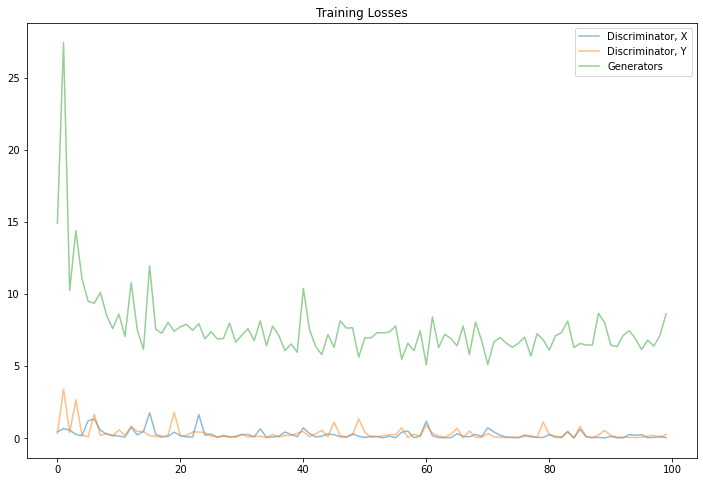

In [22]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

---
* One shortcoming of this model is that it produces fairly low-resolution images; this is an ongoing area of research.
* It may help model to converge faster, if initialized weights are used.
* This model struggles with matching colors exactly. This is because, if $G_{YtoX}$ and $G_{XtoY}$ may change the tint of an image; the cycle consistency loss may not be affected and can still be small. WE can choose to introduce a new, color-based loss term that compares $G_{YtoX}(y)$ and $y$, and $G_{XtoY}(x)$ and $x$, but then this becomes a supervised learning approach. 
* This unsupervised approach also struggles with geometric changes, like changing the apparent size of individual object in an image, so it is best suited for stylistic transformations.